# PNAS paper submission analysis

Analysing the wind characteristics of streaked shearwaters as they approach foraging points allows us to examine what conditions the birds travel in throughout foraging trips. 

## Previous study

In the most similar previous study ([Nevitt et al., 2008](https://www.pnas.org/content/105/12/4576)) investigating similar phenomena, the tracks of albatross approaching foraging points were examined and classified by their characteristics (in 4 groups: Direct, Turn, Zigzag, and Circle):

<p align="center">
   <img src=https://www.pnas.org/content/pnas/105/12/4576/F1.medium.gif alt="Albatross tracks approaching foraging">
</p>

And the histograms of relative wind bearings were examined for those categories:

 <p align="center">
    <img src=https://www.pnas.org/content/pnas/105/12/4576/F2.medium.gif alt="Relative wind histograms">
 </p>
<!-- 
<p align="center>
   <img src= alt="Relative wind histograms">
</p> -->

This study used recordings of wandering albatross with GPS and stomach temperature transmitters. Foraging points were estimates as periods with rapid drops in stomach temperature, and surface landings taken from times when birds moved at under 2.8 m/s. Wind directions and speeds from all touchdown points were estimated using QuikSCAT daily level 3 gridded ocean wind vectors. This data comes from the SeaWinds scatterometer and records wind vector fields twice daily. Wind values cannot be produced for locations within 30km of land/ice. Backscatter recorded by the satellite is then processed through a Ku-band geophysical model function which derives surface wind speeds and direction. Rain contamination can be an issue due to difficulty in separating the backscatter effect of wind vs rain. The level value refers to the processing level of the data, starting at 0 (raw) through to 3 or 4.

## Study novelty

In this study, we use bird-based wind estimations, so there is novelty in the wind data available to us, with both higher spatial and temporal resolution. We can therefore get a clearer understanding of the birds' movements relative to the wind, and potentially examine for active vs passive movement into the wind.

In [40]:
import pandas as pd
import numpy as np
import os, re, glob, pyproj, math, datetime
from sys import platform
import datatable as dt
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import re
import seaborn as sns
import math
from plotnine import ggplot, aes, geom_density
import matplotlib.animation as animation

## Data

Foraging estimates, as calculated from a recently generated [behaviour acceleration algorithm](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0254454), are read in alongside wind estimates calculated from seabird [GPS tracks](https://www.science.org/doi/10.1126/sciadv.1700097).

In [2]:
# read in 2018 data
if platform == "darwin":
    fileloc = "/Volumes/GoogleDrive/My Drive/PhD/Data/2018Shearwater/TxtDat/AxyTrek/AlgorithmOutputUpdate/PredictedForage/"
else:
    fileloc = "E:/My Drive/PhD/Data/2018Shearwater/TxtDat/AxyTrek/AlgorithmOutputUpdate/PredictedForage/"

files = glob.glob(fileloc+"*ForageGPS.txt")
tags=np.unique([re.search('([0-9\-]+)_S',f).group(1) for f in files])
forDat = []
for t in tags:
    inds=[i for i, x in enumerate([bool(re.search('[\\\\|/]'+t + '_S',f)) for f in files]) if x]
    toUse = [files[i] for i in inds]
    # go through each tags' files and read in, then combine to create forDat element dataframe
    tgdat=[]
    for tu in toUse:
        new=pd.read_csv(tu)
        new.insert(0,'yrID',str(2018) + '_' + t)
        tgdat.append(new)
    tgdat = pd.concat(tgdat)
    tgdat.loc[:,'DT'] = pd.to_datetime(tgdat.loc[:,'DT'],format="%d/%m/%Y %H:%M:%S.%f")
    forDat.append(tgdat.sort_values(by = "DT",ignore_index=True))
# add in 2019 data
if platform == "darwin":
    fileloc = "/Volumes/GoogleDrive/My Drive/PhD/Data/2019Shearwater/TxtDat/AxyTrek/AlgorithmOutput/PredictedForage/"
else:
    fileloc = "E:/My Drive/PhD/Data/2019Shearwater/TxtDat/AxyTrek/AlgorithmOutput/PredictedForage/"

files = glob.glob(fileloc+"*ForageGPS.txt")
tags=np.unique([re.search('([0-9\-]+)_S',f).group(1) for f in files])
for t in tags:
    inds=[i for i, x in enumerate([bool(re.search('[\\\\|/]'+t + '_S',f)) for f in files]) if x]
    toUse = [files[i] for i in inds]
    # go through each tags' files and read in, then combine to create forDat element dataframe
    tgdat=[]
    for tu in toUse:
        new=pd.read_csv(tu)
        new.insert(0,'yrID',str(2019) + '_' + t)
        tgdat.append(new)
    tgdat = pd.concat(tgdat)
    tgdat.loc[:,'DT'] = pd.to_datetime(tgdat.loc[:,'DT'],format="%d-%b-%Y %H:%M:%S") 
    forDat.append(tgdat.sort_values(by = "DT",ignore_index=True))

# 2018 wind data
if platform == "darwin":
    windloc = "/Volumes/GoogleDrive/My Drive/PhD/Data/2018Shearwater/WindEst/MinDat/"
else:
    windloc = "E:/My Drive/PhD/Data/2018Shearwater/WindEst/MinDat/"

wfiles = glob.glob(windloc+"*.csv")
wDat = []
for b in wfiles:
    new = pd.read_csv(b,names=["DT","Lat","Lon","BHead","X","Y"])
    new.insert(0,"yrID",str(2018) + '_' + re.findall('[0-9\-]+',re.search('.*MinDat(.+?)_S*',b).group(1))[0])
    wDat.append(new)
for df in wDat:
    df.loc[:,'DT'] = pd.to_datetime(df.loc[:,'DT'],format="%Y/%m/%d %H:%M:%S")
# 2019 wind data
if platform == "darwin":
    windloc = "/Volumes/GoogleDrive/My Drive/PhD/Data/2019Shearwater/WindEst/MinDat/"
else:
    windloc = "E:/My Drive/PhD/Data/2019Shearwater/WindEst/MinDat/"
wfiles = glob.glob(windloc+"*.csv")
for b in wfiles:
    new = pd.read_csv(b,names=["DT","Lat","Lon","BHead","X","Y"])
    new.insert(0,"yrID",str(2019) + '_' + re.findall('[0-9\-]+',re.search('.*MinDat(.+?)_S*',b).group(1))[0])
    wDat.append(new)
for df in wDat:
    df.loc[:,'DT'] = pd.to_datetime(df.loc[:,'DT'],format="%Y/%m/%d %H:%M:%S")

## Relative position/time to foraging

For each wind estimation point, the nearest proceeding foraging point is calculated with the distance and time from the next foraging spot calculated.

In [3]:
def DistTimeTo(dt,lat,lon,id,dat):
    try:
        forPoint = np.nanmin(np.where((dat['Forage'] == 1) & (dat['yrID'] == id) & (dat['DT'] > dt)))
        myProj = pyproj.Proj("+proj=utm +zone=54 +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
        forutme,forutmn=myProj(dat.loc[forPoint,'Lon'],dat.loc[forPoint,'Lat'])
        tdiff = (dat.loc[forPoint,'DT'] - dt)/np.timedelta64(1,'s')
        # azimuth1, azimuth2, distance = pyproj.Geod(ellps='WGS84').inv(dat.loc[forPoint,'Lon'],dat.loc[forPoint,'Lat'],lon,lat)
        utme,utmn = myProj(lon,lat)
        distance = np.sqrt((utme - forutme)**2 + (utmn - forutmn)**2)/1000
    except:
        tdiff = float("NaN")
        distance=float("NaN")
    return tdiff,distance
wDatn = []
for tst in wDat:
    for df in forDat:
        if (df.loc[0,'yrID'] == tst.loc[1,'yrID']) & bool(np.unique(df['DT'].dt.year)==np.unique(tst['DT'].dt.year)):
            ind = df.copy()
    tst['timeTo'],tst['distTo'] = zip(*[DistTimeTo(tst.loc[b,'DT'],tst.loc[b,'Lat'],tst.loc[b,'Lon'],tst.loc[b,'yrID'],ind) for b in range(len(tst))])

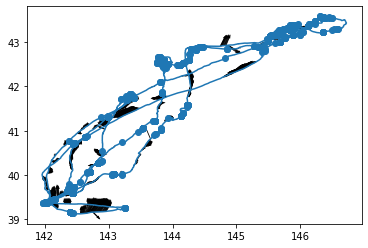

In [4]:
plt.quiver(wDat[0]['Lon'],wDat[0]['Lat'],wDat[0]['X'],wDat[0]['Y'])
for df in forDat:
    if (df.loc[0,'yrID'] == wDat[0].loc[1,'yrID']) & bool(np.unique(df['DT'].dt.year)==np.unique(wDat[0]['DT'].dt.year)):
        ind = df.copy()
plt.scatter(ind.loc[ind[ind['Forage']==1].index,'Lon'],ind.loc[ind[ind['Forage']==1].index,'Lat'])
plt.plot(ind['Lon'],ind['Lat'])

### Examining binned data

Wind data are binned into groups of 10km distances

In [5]:
for tst in wDat:
    tst['wDir'] = np.arctan2(tst['Y'],tst['X'])
    tst['wSp'] = np.sqrt(tst['X']**2 + tst['Y']**2)
    tst['rwh'] = tst['BHead'] - tst['wDir']
    tst.loc[tst[tst['rwh'] < -np.pi].index,'rwh'] = tst.loc[tst[tst['rwh'] < -np.pi].index,'rwh'] + (2*np.pi)
    tst.loc[tst[tst['rwh'] > np.pi].index,'rwh'] = tst.loc[tst[tst['rwh'] > np.pi].index,'rwh'] - (2*np.pi)
    sepLen = range(0,int(np.ceil(np.nanmax(tst['distTo'])/10)*10),10)
    tst['distGroup'] = np.nan
    for b in sepLen[0:-1]:
        tst.loc[(tst['distTo'] >= b) & (tst['distTo'] < b+10),'distGroup'] = b+10
    # tst['distGroup'] = pd.cut(tst['distTo'],np.arange(0,np.nanmax(tst['distTo']),10),labels=(np.arange(10,np.nanmax(tst['distTo']),10)))

In [6]:
for df in wDat:
    df['aligned'] = df['rwh'] + np.pi
    df.loc[df[df['aligned'] > np.pi].index,'aligned'] = df.loc[df[df['aligned'] > np.pi].index,'aligned'] - 2*np.pi
# groups = allwDat.groupby('distGroup')
# sns.displot(data=allwDat.loc[allwDat[allwDat['distTo']<100].index,:],x='aligned',kind='kde')
# fig,ax=plt.subplots(figsize=(8,6))
# for b in np.linspace(200,10,10):
#     sns.displot(groups.get_group(b)['aligned'],kind='kde',label=str(b))

# density=scipy.stats.gaussian_kde(allwDat['aligned'])

# fig, ax = plt.subplots(figsize=(8,6))
# for label, df in allwDat.groupby('distGroup'):
#     sns.displot(df.loc[df[df['distTo'] < 90].index,:],x='aligned',kind='kde',ax=ax,label=label)


# sns.displot(groups.get_group(100),x='aligned',kind='kde')

# for gp in groups:
#     sns.displot(gp.loc[gp[gp['distTo'] < 90].index,:],x='aligned',kind='kde')
# groups = allwDat.groupby('distGroup')

Text(0, 0.5, 'Lat')

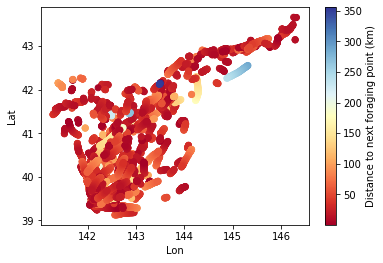

In [7]:
allwDat = pd.concat(wDat).reset_index()
cm = plt.cm.get_cmap('RdYlBu')
colours = [cm(1.*i/len(allwDat.groupby('distGroup').count())) for i in range(len(allwDat.groupby('distGroup').count()))]
xy = range(len(np.arange(0,np.nanmax(allwDat['distTo']),10)))

plt.scatter(allwDat['Lon'],allwDat['Lat'],c=allwDat['distTo'])
cb = plt.colorbar()
cb.set_label('Distance to next foraging point (km)')
plt.set_cmap(cm)
plt.xlabel('Lon')
plt.ylabel('Lat')

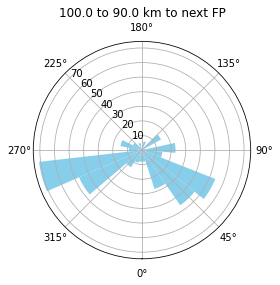

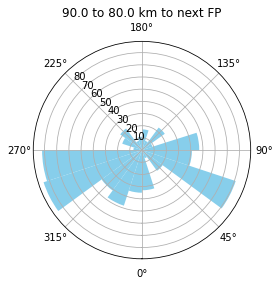

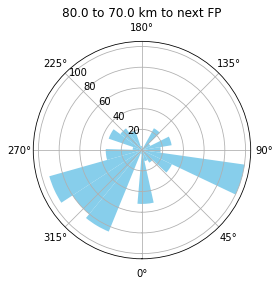

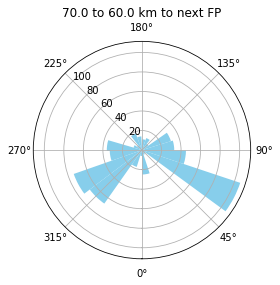

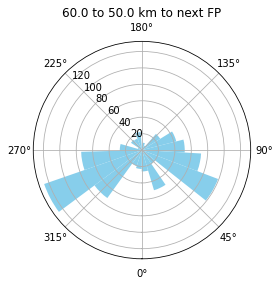

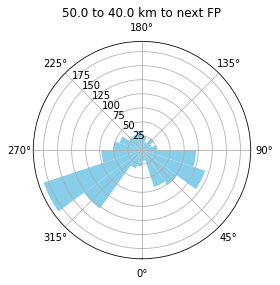

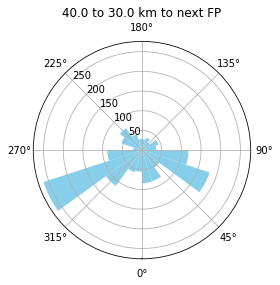

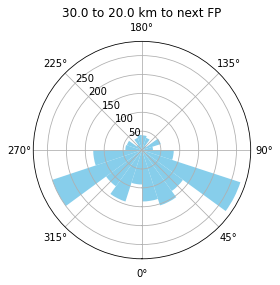

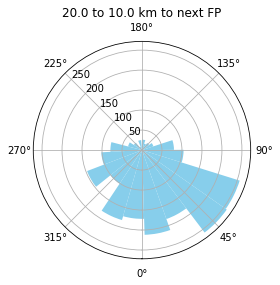

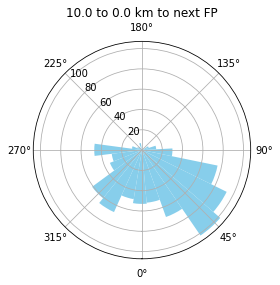

In [8]:
# plotting the data within 10km groups
# groups = allwDat.groupby('distGroup')
tst = np.linspace(100,10,10)
for b in range(len(tst)):
    plt.figure()
    ax=plt.subplot(projection='polar')
    ax.set_theta_offset(-np.pi/2)
    sel = allwDat.loc[(allwDat['distTo'] < tst[b]) & (allwDat['distTo'] >= tst[b]-10),'aligned']
    plt.hist(sel,bins=20,color='skyblue')
    ax.set_rlabel_position(225)
    plt.title(str(tst[b]) + ' to ' + str(tst[b]-10) + " km to next FP")

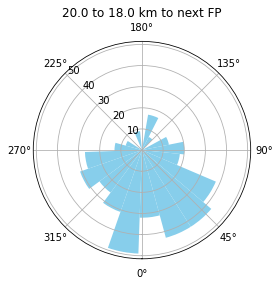

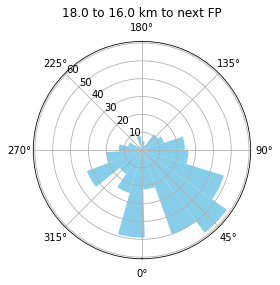

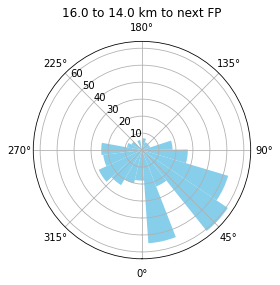

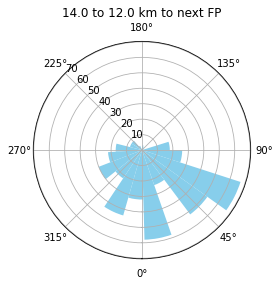

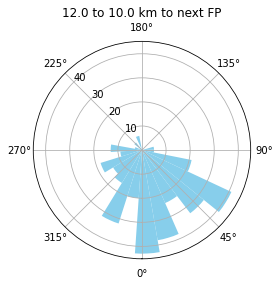

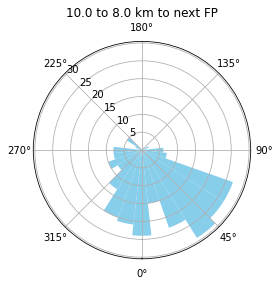

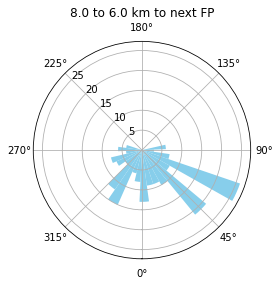

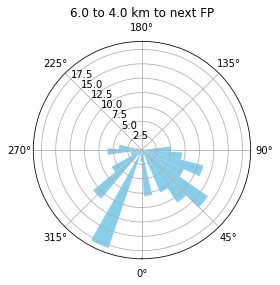

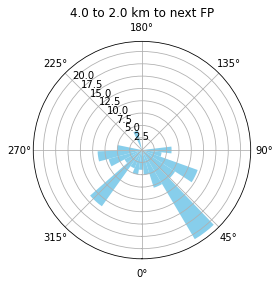

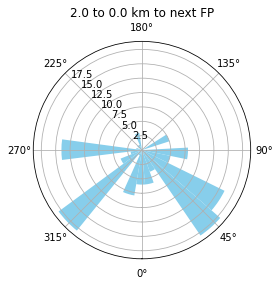

In [9]:
# plotting the data within 10km groups
# groups = allwDat.groupby('distGroup')
tst = np.linspace(20,2,10)
for b in range(len(tst)):
    plt.figure()
    ax=plt.subplot(projection='polar')
    ax.set_theta_offset(-np.pi/2)
    sel = allwDat.loc[(allwDat['distTo'] < tst[b]) & (allwDat['distTo'] >= tst[b]-2),'aligned']
    plt.hist(sel,bins=20,color='skyblue')
    ax.set_rlabel_position(225)
    plt.title(str(tst[b]) + ' to ' + str(tst[b]-2) + " km to next FP")

In [10]:
# add foraging number to foraging data
for df in forDat:
    df['forageNo'] = np.nan
    forPoints = df['Forage']==1
    forEd = np.where(np.diff(forPoints.astype(int)) == -1)[0]
    if df['Forage'].iloc[-1] == 1:
        forEd=np.append(forEd,len(df))
    for b in range(len(forEd)):
        if b == 0:
            df.loc[0:forEd[b],'forageNo'] = b+1
        else:
            df.loc[(forEd[b-1]+1):forEd[b],'forageNo'] = b+1

In [11]:
# calculate speed (kph)
def calSpd(lat,lon,dt):
    myProj = pyproj.Proj("+proj=utm +zone=54 +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
    utme,utmn=myProj(lon,lat)
    tdiff = np.diff(dt)/np.timedelta64(1,'h')
    distance = np.sqrt(np.diff(utme)**2 + np.diff(utmn)**2)/1000
    spTrav = distance/tdiff
    return utme,utmn,np.insert(spTrav,0,np.nan)

In [12]:
# # add speed to foraging data
# for df in forDat:
#     df['utme'],df['utmn'],df['spTrav'] = calSpd(df['Lat'],df['Lon'],df['DT'])
#     # add distance and time to next foraging
#     df['timeTo'],df['distTo'] = zip(*[DistTimeTo(df.loc[b,'DT'],df.loc[b,'Lat'],df.loc[b,'Lon'],df.loc[b,'yrID'],df) for b in range(len(df))])

In [13]:
# for df in forDat:
#     df.loc[df[df['Forage']==1].index,'distTo'] = np.nan
#     df.loc[df[df['Forage']==1].index,'timeTo'] = np.nan

In [14]:
# allFor = pd.concat(forDat)
# plt.scatter(allFor['distTo'],allFor['spTrav'])

In [15]:
# add distance from FkOshi
def DistFK(lat,lon):
    myProj = pyproj.Proj("+proj=utm +zone=54 +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
    FkUTME,FkUTMN = myProj(141.998165,39.402289)
    utme,utmn = myProj(lon,lat)
    distance = np.sqrt((utme - FkUTME)**2 + (utmn - FkUTMN)**2)/1000
    return distance
for tst in wDat:
    tst['distFk'] = [DistFK(tst.loc[b,'Lat'],tst.loc[b,'Lon']) for b in range(len(tst))]

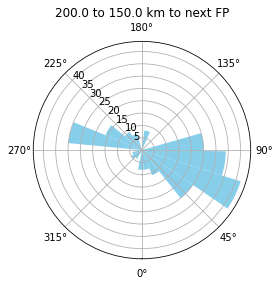

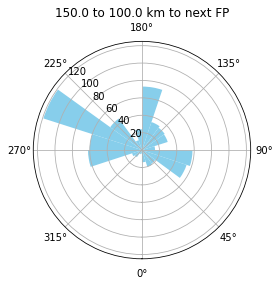

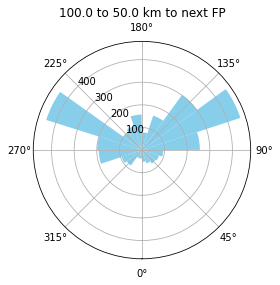

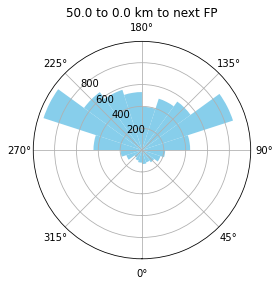

In [16]:
# plotting the data in 50km groups from FkOshi
allwDat = pd.concat(wDat)
tst = np.linspace(200,50,4)
for b in range(len(tst)):
    plt.figure()
    ax=plt.subplot(projection='polar')
    ax.set_theta_offset(-np.pi/2)
    sel = allwDat.loc[(allwDat['distTo'] < tst[b]) & (allwDat['distTo'] >= tst[b]-50),'rwh']
    plt.hist(sel,bins=20,color='skyblue')
    ax.set_rlabel_position(225)
    plt.title(str(tst[b]) + ' to ' + str(tst[b]-50) + " km to next FP")

## Data per individual

Wishing to look at the wind conditions of individuals flying towards foraging spots. This way, we have an idea of how the birds are using winds on approach. So therefore, we can explore the wind data to find how much wind data is available prior to each foraging point.

In [17]:
for tst in wDat:
    for df in forDat:
        if df.loc[0,'yrID'] == tst.loc[0,'yrID']:
            ind = df.copy()
    forPoints = np.where(ind['Forage'] == 1)[0]
    forNo = range(len(forPoints))
    for b in range(len(tst)):
        try:
            tst.loc[b,'forageNo'] = forNo[np.nanmin(np.where(ind.loc[forPoints,'DT'] > tst.loc[b,'DT'])[0])] +1
        except:
            pass

Text(0, 0.5, 'Lat')

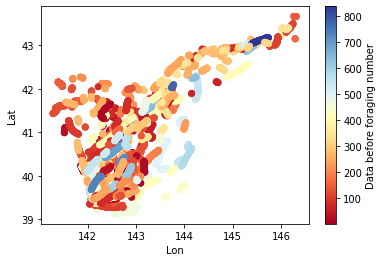

In [18]:
allwDat = pd.concat(wDat).reset_index()
cm = plt.cm.get_cmap('RdYlBu')
colours = [cm(1.*i/len(allwDat.groupby('forageNo').count())) for i in range(len(allwDat.groupby('forageNo').count()))]
xy = range(len(np.arange(0,np.nanmax(allwDat['distTo']),10)))

plt.scatter(allwDat['Lon'],allwDat['Lat'],c=allwDat['forageNo'])
cb = plt.colorbar()
cb.set_label('Data before foraging number')
plt.set_cmap(cm)
plt.xlabel('Lon')
plt.ylabel('Lat')

Text(0.5, 1.0, 'Number of wind estimates per individual within 50km of foraging point')

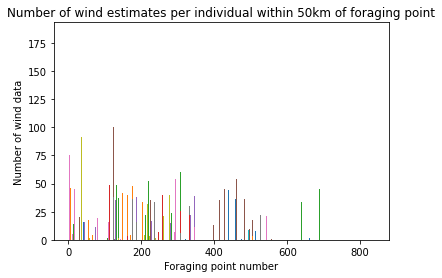

In [19]:
# wind counts for each foraging point within 2 hours of next FP
# sub = wDat.loc[wDat[wDat['timeTo'] < 3600*2].index,:]
# groups = sub.groupby('forageNo')
# forWdat = pd.DataFrame(groups.size())
# forWdat['forageNo'] = forWdat.index
# plt.bar(forWdat['forageNo'],forWdat[0])
# plt.xlabel('Foraging point ID')
# plt.ylabel('Number of wind values prior to forage point')
# plt.title('Wind data available before each foraging')
# fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2)
# for yr in [2018,2019]:    
    # if yr == 2018:
tmp50=[df.loc[df[(df['distTo']<50)].index,:].groupby('forageNo').size() for df in wDat]
for t in tmp50:
    plt.bar(t.index,t)
plt.xlabel('Foraging point number')
plt.ylabel('Number of wind data')
plt.title("Number of wind estimates per individual within 50km of foraging point")
    # else:
    #     tmp50=[df.loc[df[(df['distTo']<50) & (np.unique(df['DT'].dt.year) == yr)].index,:].groupby('forageNo').size() for df in wDat]
    #     for t in tmp50:
    #         ax2.bar(t.index,t)
    #     ax2.xlabel('Foraging point number')
    #     ax2.ylabel('Number of wind data')
    #     ax2.title("2019 wind estimates per individual within 50km of foraging point")
# plt.legend(np.unique(pd.concat(wDat)['yrID']))

Text(0.5, 1.0, 'Number of wind estimates per individual within 50km of foraging point')

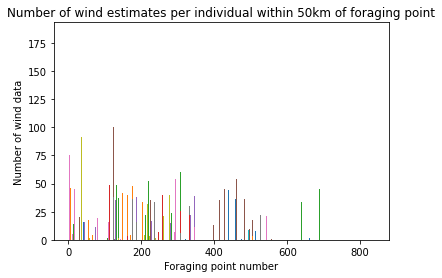

In [20]:
# for yr in [2018,2019]:    
#     tmp50=[df.loc[df[(df['distTo']<50) & (np.unique(df['DT'].dt.year) == yr)].index,:].groupby('forageNo').size() for df in wDat]
#     for t in tmp50:
#         plt.bar(t.index,t)
#     plt.subplot()
#     plt.xlabel('Foraging point number')
#     plt.ylabel('Number of wind data')
#     plt.title("Number of wind estimates per individual within 50km of foraging point")
#     plt.legend(np.unique(pd.concat(wDat)['yrID']))
tmp50 = [df.loc[df[df['distTo']<50].index,:].groupby('forageNo').size() for df in wDat]
for t in tmp50:
    plt.bar(t.index,t)
plt.subplot()
plt.xlabel('Foraging point number')
plt.ylabel('Number of wind data')
plt.title("Number of wind estimates per individual within 50km of foraging point")
# plt.legend(np.unique(pd.concat(wDat)['yrID']))

Text(0.5, 1.0, 'Number of wind estimates per individual within 100km of foraging point')

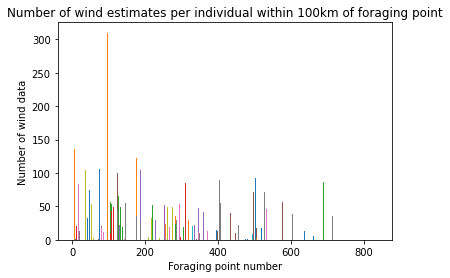

In [21]:
tmp100=[df.loc[df[df['distTo']<100].index,:].groupby('forageNo').size() for df in wDat]
for t in tmp100:
    plt.bar(t.index,t)
plt.xlabel('Foraging point number')
plt.ylabel('Number of wind data')
plt.title("Number of wind estimates per individual within 100km of foraging point")
# plt.legend(np.unique(pd.concat(wDat)['yrID']))

If we explore the data for foraging points with the most available wind data, we can then produce the following graph, showing the birds track towards the foraging point with available wind vectors.

Text(0.5, 1.0, 'Wind vectors <50km from next foraging point')

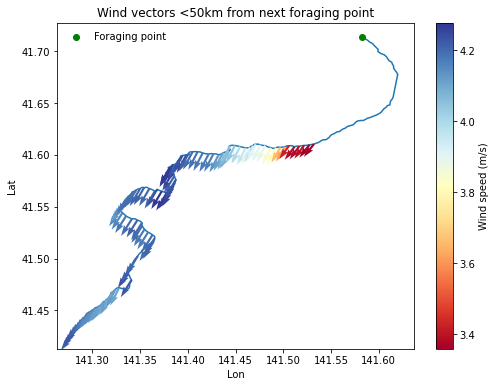

In [22]:
# find the largest number of wind data before foraging point for within 50km in each tag (nan refers to no data under those conditions)
toTst = []
for tmp in range(len(tmp50)):
    try:
        toTst.append(tmp50[tmp].idxmax())
    except:
        toTst.append(np.nan)
toTst
# take example of tag 6
sub = wDat[5].loc[(wDat[5]['forageNo'] == toTst[5]) & (wDat[5]['distTo'] < 50),:]
for df in forDat:
        if df.loc[0,'yrID'] == sub['yrID'].iloc[0]:
            ind = df.copy()

nxtForPt = np.nanmin(np.where((ind['Forage'] == 1) & (ind['DT'] > sub['DT'].iloc[0])))
plt.figure(figsize=(8,6))
plt.plot(ind.loc[(ind['DT'] >= sub['DT'].iloc[0]) & (ind['DT'] < (ind.loc[nxtForPt,'DT'])),'Lon'],
ind.loc[(ind['DT'] >= sub['DT'].iloc[0]) & (ind['DT'] < (ind.loc[nxtForPt,'DT'])),'Lat'],zorder=0)
arrows=plt.quiver(sub['Lon'],sub['Lat'],sub['X'],sub['Y'],sub['wSp'])
plt.scatter(ind.loc[nxtForPt,'Lon'],ind.loc[nxtForPt,'Lat'],c='Green',label='Foraging point')
plt.legend(scatterpoints=1, frameon=False, labelspacing=1)
cb=plt.colorbar(arrows)
cb.set_label("Wind speed (m/s)")
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.title("Wind vectors <50km from next foraging point")

Repeating this process for all the largest numbers of available wind vectors for each tag within 50 km of a foraging point gives the following.

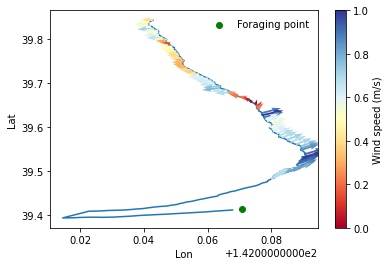

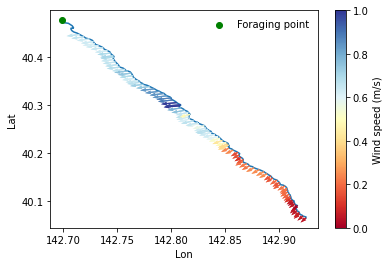

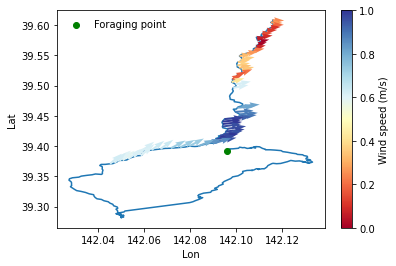

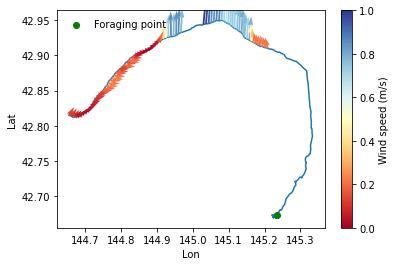

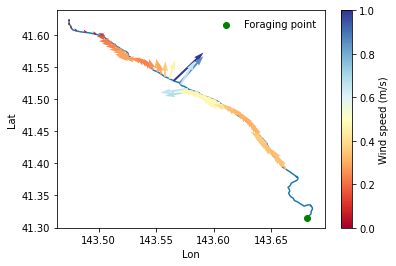

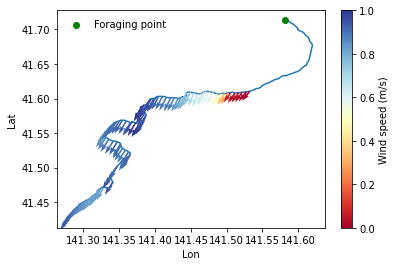

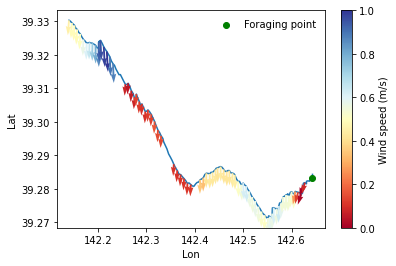

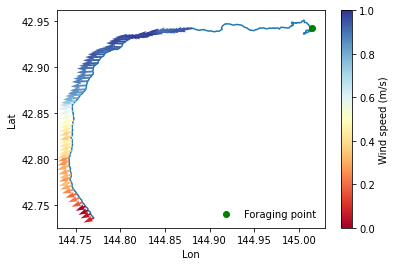

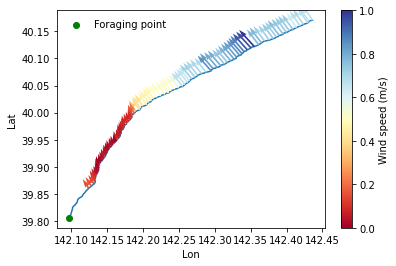

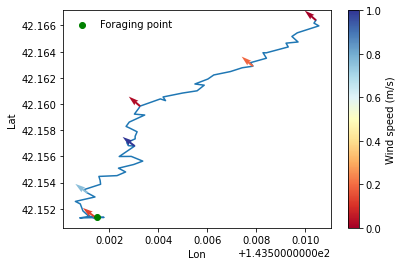

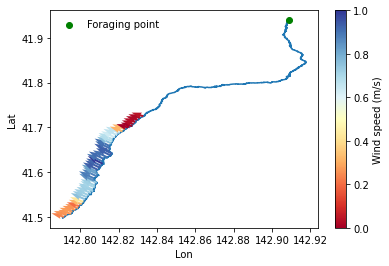

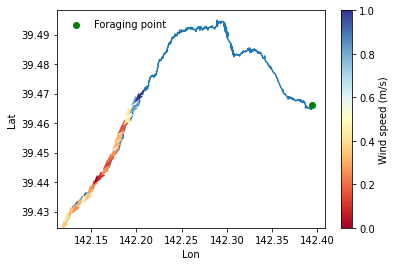

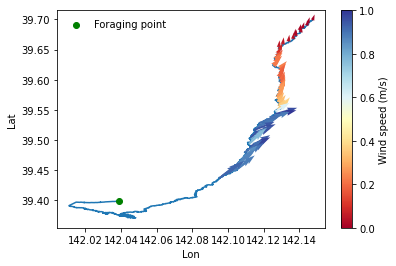

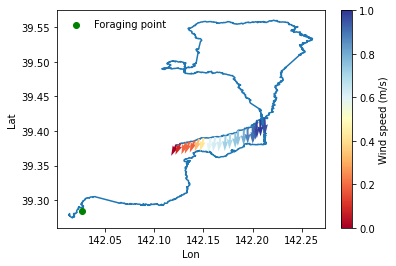

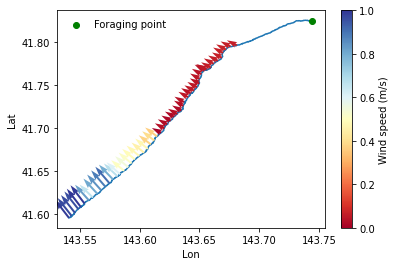

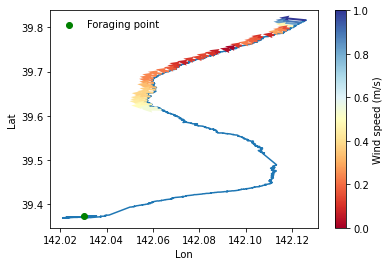

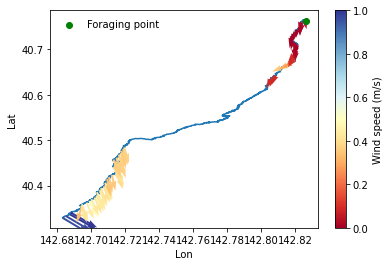

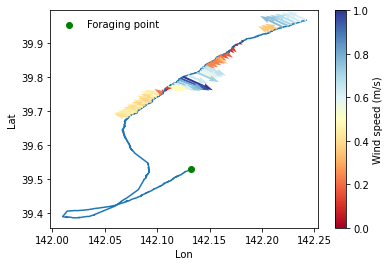

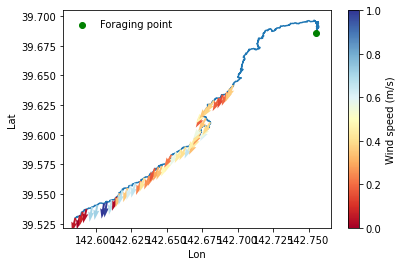

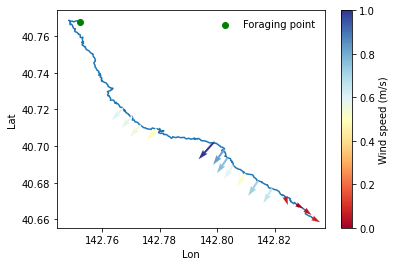

In [23]:
# create multiplot of the foraging point with the most available wind values <50 km from the next foraging point
for b in range(len(toTst)):
    if np.isnan(toTst[b]) == False:
        sub = wDat[b].loc[(wDat[b]['forageNo'] == toTst[b]) & (wDat[b]['distTo'] < 50),:].copy()
    for df in forDat:
        if df.loc[0,'yrID'] == sub['yrID'].iloc[0]:
            ind = df.copy()
    nxtForPt = np.nanmin(np.where((ind['Forage'] == 1) & (ind['DT'] > sub['DT'].iloc[0])))
    plt.subplots()
    plt.plot(ind.loc[(ind['DT'] >= sub['DT'].iloc[0]) & (ind['DT'] < (ind.loc[nxtForPt,'DT'])),'Lon'],
    ind.loc[(ind['DT'] >= sub['DT'].iloc[0]) & (ind['DT'] < (ind.loc[nxtForPt,'DT'])),'Lat'],zorder=0)
    plt.quiver(sub['Lon'],sub['Lat'],sub['X'],sub['Y'],sub['wSp'])
    plt.scatter(ind.loc[nxtForPt,'Lon'],ind.loc[nxtForPt,'Lat'],c='Green',label='Foraging point')
    plt.legend(scatterpoints=1, frameon=False, labelspacing=1)
    cb=plt.colorbar()
    cb.set_label("Wind speed (m/s)")
    plt.xlabel('Lon')
    plt.ylabel('Lat')
    plt.show()

plt.show()

(array([135., 501., 246., 168., 118.,  89.,  47.,  19.,  13.,  20.]),
 array([ 0.04465085,  1.48851087,  2.93237089,  4.37623091,  5.82009093,
         7.26395095,  8.70781097, 10.15167099, 11.59553101, 13.03939103,
        14.48325105]),
 <BarContainer object of 10 artists>)

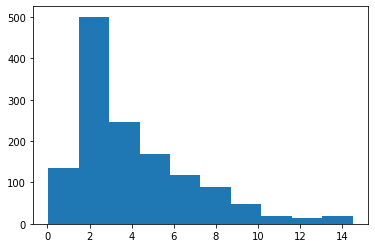

In [24]:
plt.hist(wDat[0]['wSp'])

In [25]:
# find the relative wind direction to direction of foraging site (are birds downwind?)

def PosForHd(dt,lat,lon,id,dat):
    try:
        forPoint = np.nanmin(np.where((dat['Forage'] == 1) & (dat['yrID'] == id) & (dat['DT'] > dt)))
        myProj = pyproj.Proj("+proj=utm +zone=54 +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
        forutme,forutmn=myProj(dat.loc[forPoint,'Lon'],dat.loc[forPoint,'Lat'])
        utme,utmn = myProj(lon,lat)
        forHd = math.atan2(utmn-forutmn, utme-forutme)
    except:
        forHd=float("NaN")
    return forHd
for tst in wDat:
    for df in forDat:
        if (df.loc[0,'yrID'] == tst.loc[1,'yrID']):
            ind = df.copy()
    tmp = [PosForHd(tst.loc[b,'DT'],tst.loc[b,'Lat'],tst.loc[b,'Lon'],tst.loc[b,'yrID'],ind) for b in range(len(tst))]
    tst.insert(len(tst.columns),'forHd',tmp)
    tst['RelForHd'] = tst['forHd'] - tst['wDir']

## Extra analysis on individual scale

I believe an important step would be to test for changes in wind usage across individuals. One example would be checking that, if there is a significant change in the headings of an individual as they approach foraging spots, to see if that is replicated by a change in the bird's heading itself. This would reflect an active change by the bird to alter wind usage, providing stronger evidence that birds are in fact using winds to source olfactory signals, as opposed to our results appearing as a result of circumstance.

In [26]:
# take average heading (5 min window) throughout tracks
for df in forDat:
    myProj = pyproj.Proj("+proj=utm +zone=54 +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
    forutme,forutmn=myProj(df['Lon'],df['Lat'])
    de = np.diff(forutme)
    dn = np.diff(forutmn)
    tst=[math.atan2(dn[b],de[b]) for b in range(len(de))]
    clean=list(tst)
    clean.insert(0,np.nan)
    df['Head'] = clean
    df['aveHead'] = df['Head'].rolling(5,min_periods=2).mean()
    df['stdHead'] = df['Head'].rolling(5,min_periods=2).std()

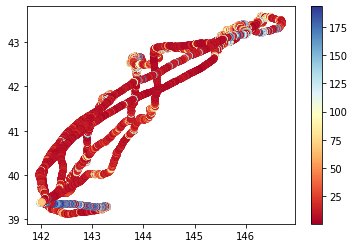

In [27]:
plt.scatter(forDat[0]['Lon'],forDat[0]['Lat'],c=forDat[0]['stdHead']*(180/np.pi))
cb=plt.colorbar()

In [28]:
# find large angle changes prior to foraging points
for df in forDat:
    chgDir = np.diff(df['Head'])
    chgPoints = np.where(chgDir > (45*(np.pi/180)))

In [29]:
# find the number of continuous wind records that switched from side to headwinds
hdTrans = []
transTrend = []
strHd = []
hdRng = 20*(np.pi/180)
for df in wDat:
    # go by foraging number
    nos = np.unique(df['forageNo'])
    newTrans = []
    newTrend =[]
    newStrt = []
    for n in nos[~np.isnan(nos)]:
        tst = df.loc[df[df['forageNo'] == n].index,:]
        newTrans.append(np.abs(0 - tst['aligned'].iloc[-1])-np.abs(0 - tst['aligned'].iloc[0]))
        newStrt.append(np.abs(tst['aligned'].iloc[0]) < hdRng)
        newTrend.append(np.abs(tst['aligned'].iloc[-1]) < hdRng)
    hdTrans.append(newTrans)
    transTrend.append(newTrend)
    strHd.append(newStrt)

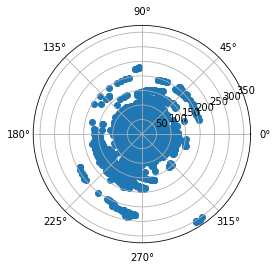

In [30]:
ax=plt.subplot(projection='polar')
plt.scatter(allwDat['aligned'],allwDat['distTo'])

In [31]:
# # test for winds heading from the foraging location
# for df in wDat:
#     for f in forDat:
#         if f.loc[0,'yrID'] == df.loc[0,'yrID']:
#             ind = f
#     for no in np.unique(df["forageNo"]):
#         tst = df.loc[df[df['forageNo']==no].index,:]
#         forPoint = np.nanmin(np.where((f['DT']>tst['DT'].iloc[-1]) & (f['Forage']==1))[0])
#         # forUTMN,forUTME

<AxesSubplot:xlabel='aligned', ylabel='Density'>

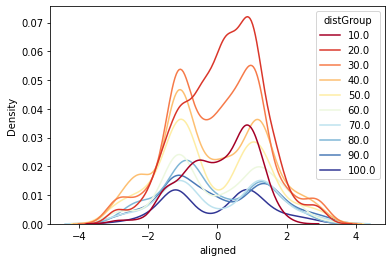

In [34]:
fig,ax=plt.subplots()
sns.kdeplot(data=allwDat.loc[allwDat[allwDat['distTo']<100].index,:], x='aligned',hue='distGroup',palette="RdYlBu")
# g.set(xlim=(-np.pi,np.pi))

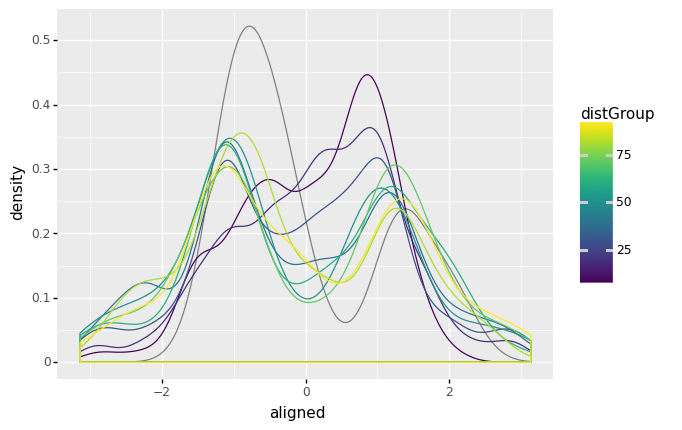

<ggplot: (112349057473)>

In [39]:
(
    ggplot(allwDat.loc[allwDat[allwDat['distTo']<90].index,:])
    + aes(x = "aligned", group = 'distGroup', colour = 'distGroup')
    + geom_density(alpha=.2)
)

In [52]:
def get_data(df,distGroup,column):
    data = df.loc[df[df['distGroup']==distGroup].index,column]
    return data

In [54]:
%matplotlib notebook
title = 'Relative wind use'
d = get_data(allwDat,100,'aligned')

In [55]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=2, metadata=dict(artist='Me'), bitrate=1800)

In [56]:
fig = plt.figure(figsize=(10,6))
plt.xlim(-np.pi, np.pi)
plt.ylim(0, 500)
plt.xlabel('Relative wind heading',fontsize=20)
plt.title('Relative wind headings on foraging approach',fontsize=20)

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Relative wind headings on foraging approach')

In [57]:
def animate(i):
    data = get_data(allwDat,i*10,'aligned') #select data range
    p = plt.hist(data.index, color="r")
    p.tick_params(labelsize=17)
    plt.setp(p.lines,linewidth=7)

In [61]:
ani = animation.FuncAnimation(fig, animate, frames=9, repeat=True)

In [46]:
for tst in yDat:
    for df in forDat:
        if df.loc[0,'yrID'] == tst.loc[1,'yrID']:
            ind = df.copy()
    tmp = [DistTimeTo(tst.loc[b,'DT'],tst.loc[b,'Lat'],tst.loc[b,'Lon'],tst.loc[b,'yrID'],ind) for b in range(len(tst))]
    tst.insert(len(tst.columns),'timeTo',[row[0] for row in tmp])
    tst.insert(len(tst.columns),'distTo',[row[1] for row in tmp])

In [47]:
for tst in yDat:
    for df in forDat:
        if df.loc[0,'yrID'] == tst.loc[0,'yrID']:
            ind = df.copy()
    forPoints = np.where(ind['Forage'] == 1)[0]
    forNo = range(len(forPoints))
    for b in range(len(tst)):
        try:
            tst.loc[b,'forageNo'] = forNo[np.nanmin(np.where(ind.loc[forPoints,'DT'] > tst.loc[b,'DT'])[0])] +1
        except:
            pass

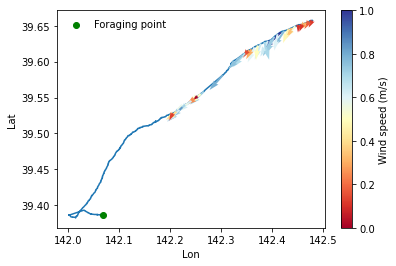

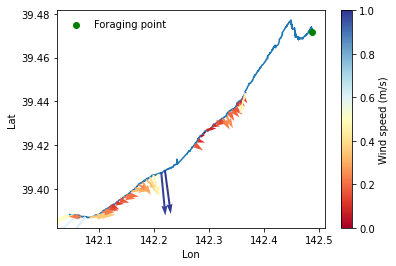

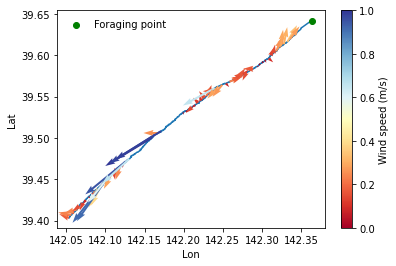

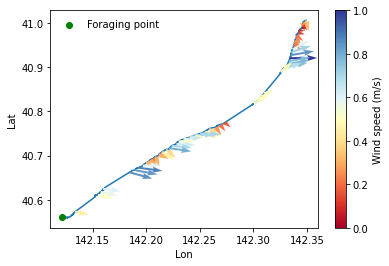

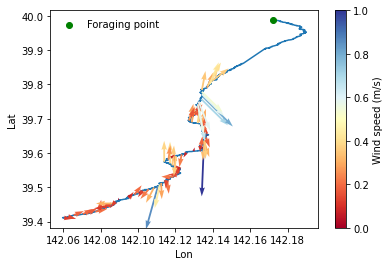

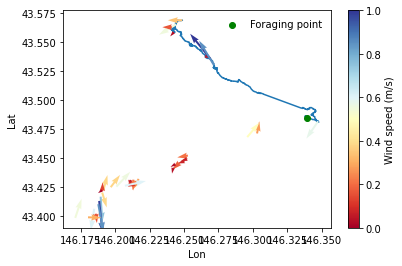

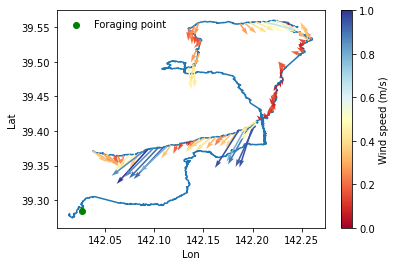

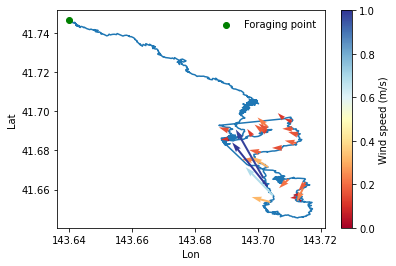

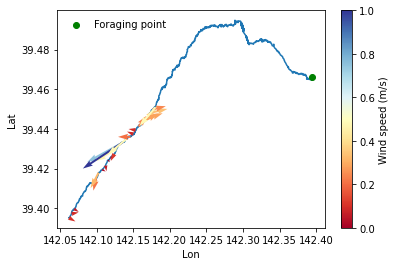

In [48]:
ytmp50 = [df.loc[df[(df['distTo']<50) & (df['timeTo']<(100*60))].index,:].groupby('forageNo').size() for df in yDat]
# find the largest number of wind data before foraging point for within 50km in each tag (nan refers to no data under those conditions)
toTst = []
for tmp in range(len(ytmp50)):
    try:
        toTst.append(ytmp50[tmp].idxmax())
    except:
        toTst.append(np.nan)

for b in range(len(toTst)):
    if np.isnan(toTst[b]) == False:
        sub = yDat[b].loc[(yDat[b]['forageNo'] == toTst[b]) & (yDat[b]['distTo'] < 50),:].copy()
    for df in forDat:
        if df.loc[0,'yrID'] == sub['yrID'].iloc[0]:
            ind = df.copy()
    ind['DT']=ind['DT']-np.timedelta64(9,'h')
    nxtForPt = np.nanmin(np.where((ind['Forage'] == 1) & (ind['DT'] > sub['DT'].iloc[0])))
    plt.subplots()
    plt.plot(ind.loc[(ind['DT'] >= sub['DT'].iloc[0]) & (ind['DT'] < (ind.loc[nxtForPt,'DT'])),'Lon'],
    ind.loc[(ind['DT'] >= sub['DT'].iloc[0]) & (ind['DT'] < (ind.loc[nxtForPt,'DT'])),'Lat'],zorder=0)
    plt.quiver(sub['Lon'],sub['Lat'],sub['wSp']*np.cos(sub['wDir']),sub['wSp']*np.sin(sub['wDir']),sub['wSp'])
    plt.scatter(ind.loc[nxtForPt,'Lon'],ind.loc[nxtForPt,'Lat'],c='Green',label='Foraging point')
    plt.legend(scatterpoints=1, frameon=False, labelspacing=1)
    cb=plt.colorbar()
    cb.set_label("Wind speed (m/s)")
    plt.xlabel('Lon')
    plt.ylabel('Lat')
    plt.show()

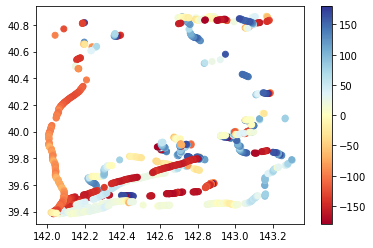

In [56]:
plt.scatter(yDat[0]['Lon'],yDat[0]['Lat'],c=yDat[0]['aveDir'])
plt.colorbar()
utme,utmn=myProj(yDat[0]['Lon'],yDat[0]['Lat']
plt.quiver(yDat[0]['Lon'],yDat[0]['Lat'],
)

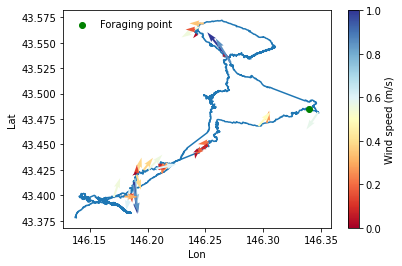

In [49]:
b=5
if np.isnan(toTst[b]) == False:
    sub = yDat[b].loc[(yDat[b]['forageNo'] == toTst[b]) & (yDat[b]['distTo'] < 50),:].copy()
for df in forDat:
    if df.loc[0,'yrID'] == sub['yrID'].iloc[0]:
        ind = df.copy()
ind['DT']=ind['DT']-np.timedelta64(9,'h')
nxtForPt = np.nanmin(np.where((ind['Forage'] == 1) & (ind['DT'] > sub['DT'].iloc[0])))
plt.subplots()
plt.plot(ind.loc[(ind['DT'] >= (ind['DT'][nxtForPt] - np.timedelta64(300,'m'))) & (ind['DT'] < (ind.loc[nxtForPt,'DT'] + np.timedelta64(300,'m'))),'Lon'],
ind.loc[(ind['DT'] >= (ind['DT'][nxtForPt] - np.timedelta64(300,'m'))) & (ind['DT'] < (ind.loc[nxtForPt,'DT'] + np.timedelta64(300,'m'))),'Lat'],zorder=0)
plt.quiver(sub['Lon'],sub['Lat'],sub['wSp']*np.cos(sub['wDir']),sub['wSp']*np.sin(sub['wDir']),sub['wSp'])
plt.scatter(ind.loc[nxtForPt,'Lon'],ind.loc[nxtForPt,'Lat'],c='Green',label='Foraging point')
plt.legend(scatterpoints=1, frameon=False, labelspacing=1)
cb=plt.colorbar()
cb.set_label("Wind speed (m/s)")
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.show()

In [50]:
for df in yDat:
    df['distGroup'] = np.nan
    sepLen = range(0,int(np.ceil(np.nanmax(df['distTo'])/10)*10),10)
    for b in sepLen[0:-1]:
        df.loc[(df['distTo'] >= b) & (df['distTo'] < b+10),'distGroup'] = b+10
    df['rwh'] = (df['aveDir']/(180/np.pi)) - df['wDir']
    df['aligned'] = df['rwh'] + np.pi
    df.loc[df[df['aligned'] > np.pi].index,'aligned'] = df.loc[df[df['aligned'] > np.pi].index,'aligned'] - 2*np.pi

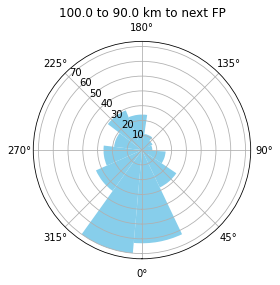

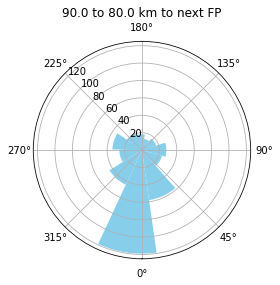

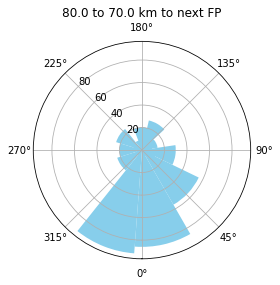

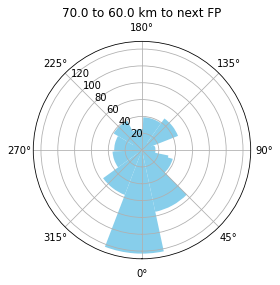

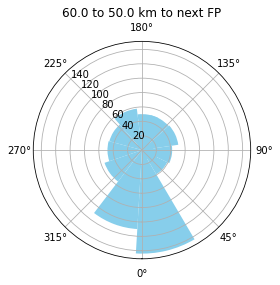

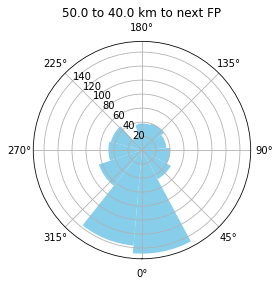

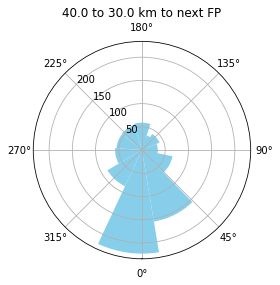

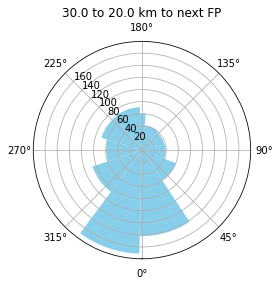

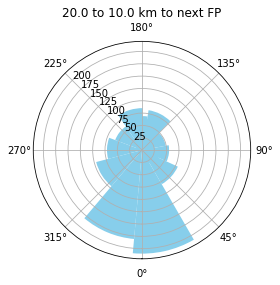

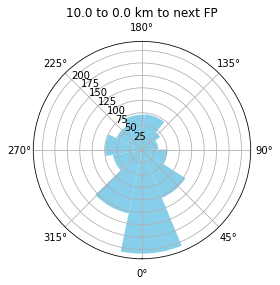

In [53]:
# plotting the data within 10km groups
# groups = allyDat.groupby('distGroup')
allyDat = pd.concat(yDat).reset_index()
tst = np.linspace(100,10,10)
for b in range(len(tst)):
    plt.figure()
    ax=plt.subplot(projection='polar')
    ax.set_theta_offset(-np.pi/2)
    sel = allyDat.loc[(allyDat['distTo'] < tst[b]) & (allyDat['distTo'] >= tst[b]-10),'rwh']
    plt.hist(sel,bins=20,color='skyblue')
    ax.set_rlabel_position(225)
    plt.title(str(tst[b]) + ' to ' + str(tst[b]-10) + " km to next FP")

<AxesSubplot:xlabel='aligned', ylabel='Density'>

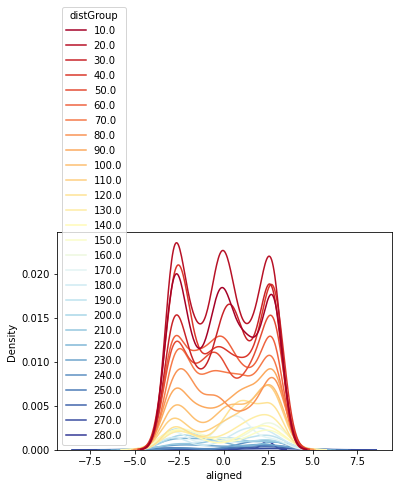

In [52]:
sns.kdeplot(data=allyDat,x='aligned',hue='distGroup',palette="RdYlBu")

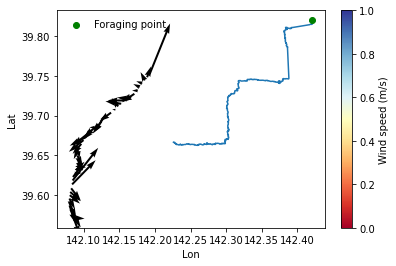

In [90]:
b=2
if np.isnan(toTst[b]) == False:
    sub = yDat[b].loc[(yDat[b]['forageNo'] == toTst[b]) & (yDat[b]['distTo'] < 50),:].copy()
for df in forDat:
    if df.loc[0,'yrID'] == sub['yrID'].iloc[0]:
        ind = df.copy()
nxtForPt = np.nanmin(np.where((ind['Forage'] == 1) & (ind['DT'] > sub['DT'].iloc[0])))
plt.subplots()
plt.plot(ind.loc[(ind['DT'] >= sub['DT'].iloc[0]) & (ind['DT'] < (ind.loc[nxtForPt,'DT'])),'Lon'],
ind.loc[(ind['DT'] >= sub['DT'].iloc[0]) & (ind['DT'] < (ind.loc[nxtForPt,'DT'])),'Lat'],zorder=0)
arrows=plt.quiver(sub['Lon'],sub['Lat'],np.cos(sub['wDir'])*sub['wSp'],np.sin(sub['wDir'])*sub['wSp'])
plt.scatter(ind.loc[nxtForPt,'Lon'],ind.loc[nxtForPt,'Lat'],c='Green',label='Foraging point')
plt.legend(scatterpoints=1, frameon=False, labelspacing=1)
cb=plt.colorbar()
cb.set_label("Wind speed (m/s)")
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.show()

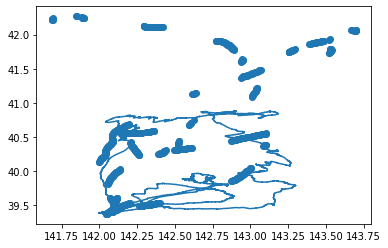

In [95]:
b=2
if np.isnan(toTst[b]) == False:
    sub = yDat[b].loc[(yDat[b]['forageNo'] == toTst[b]) & (yDat[b]['distTo'] < 50),:].copy()
for df in forDat:
    if df.loc[0,'yrID'] == sub['yrID'].iloc[0]:
        ind = df.copy()
plt.plot(ind['Lon'],ind['Lat'])
plt.scatter(wDat[b]['Lon'],wDat[b]['Lat'])
# nxtForPt = np.nanmin(np.where((ind['Forage'] == 1) & (ind['DT'] > sub['DT'].iloc[0])))
# plt.subplots()
# plt.plot(ind.loc[(ind['DT'] >= sub['DT'].iloc[0]) & (ind['DT'] < (ind.loc[nxtForPt,'DT'])),'Lon'],
# ind.loc[(ind['DT'] >= sub['DT'].iloc[0]) & (ind['DT'] < (ind.loc[nxtForPt,'DT'])),'Lat'],zorder=0)
# arrows=plt.quiver(sub['Lon'],sub['Lat'],np.cos(sub['wDir'])*sub['wSp'],np.sin(sub['wDir'])*sub['wSp'])
# plt.scatter(ind.loc[nxtForPt,'Lon'],ind.loc[nxtForPt,'Lat'],c='Green',label='Foraging point')
# plt.legend(scatterpoints=1, frameon=False, labelspacing=1)
# cb=plt.colorbar()
# cb.set_label("Wind speed (m/s)")
# plt.xlabel('Lon')
# plt.ylabel('Lat')
# plt.show()

In [93]:
ind.loc[0:5,:]

,yrID,DT,Lat,Lon,Forage,Head,aveHead,stdHead
0,2019_5,2019-08-24 04:09:54,39.39598,142.01515,0,NaN,NaN,NaN
1,2019_5,2019-08-24 04:09:59,39.39578,142.01581,0,-0.361091,NaN,NaN
2,2019_5,2019-08-24 04:10:04,39.39560,142.01629,0,-0.438955,-0.400023,0.055058
3,2019_5,2019-08-24 04:10:09,39.39542,142.01687,0,-0.369231,-0.389759,0.042799
4,2019_5,2019-08-24 04:10:14,39.39532,142.01731,0,-0.273679,-0.360739,0.067748
5,2019_5,2019-08-24 04:10:19,39.39490,142.01764,0,-1.012052,-0.491002,0.297126


In [94]:
yDat[b].loc[0:5,:]

,index,yrID,time,Lat,Lon,aveDir,wDir,wSp,Resnorm,DT,timeTo,distTo,forageNo
0,198,2019_5,"2019/08/22,19:19:59",39.38736,142.04657,-0.083324,0.343466,1.884947,602.375302,2019-08-22 19:19:59,118585.0,0.988614,1.0
1,210,2019_5,"2019/08/22,19:20:59",39.38700,142.04784,5.021793,0.471500,2.387457,788.411483,2019-08-22 19:20:59,118525.0,1.101612,1.0
2,222,2019_5,"2019/08/22,19:21:59",39.38605,142.05244,-2.341356,0.249436,2.021413,980.380985,2019-08-22 19:21:59,118465.0,1.508627,1.0
3,234,2019_5,"2019/08/22,19:23:00",39.38677,142.05573,12.670562,0.195395,1.520648,964.110614,2019-08-22 19:23:00,118404.0,1.780228,1.0
4,246,2019_5,"2019/08/22,19:23:59",39.38822,142.06022,20.245600,0.956261,0.945844,1082.748144,2019-08-22 19:23:59,118345.0,2.160025,1.0
5,258,2019_5,"2019/08/22,19:24:59",39.38868,142.06248,40.575720,1.237375,1.268607,1159.495413,2019-08-22 19:24:59,118285.0,2.355310,1.0
